In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
!pip install -q scikit-learn-extra

In [3]:
# Step - 1: Load DataSet

Data = pd.read_csv(r"/Users/lakshminarayanalatchireddi/Downloads/recs_cleaned_for_analysis.csv")

print("Shape of dataset:", Data.shape)
display(Data.head())
print(Data.info())

Shape of dataset: (18496, 13)


,DOEID,REGIONC,TYPEHUQ,YEARMADERANGE,TOTSQFT_EN,WALLTYPE,ROOFTYPE,ADQINSUL,HHSEX,HHAGE,EMPLOYHH,MONEYPY,KWH
0,100001,WEST,2,4,2100,1,5,2,1,65,3,13,12521.48
1,100002,SOUTH,5,5,590,1,-2,2,1,79,3,6,5243.05
2,100003,WEST,5,3,900,1,-2,2,2,82,3,11,2387.64
3,100004,SOUTH,2,5,2100,3,5,2,2,70,3,10,9275.07
4,100005,NORTHEAST,5,3,800,7,-2,2,2,30,1,16,5869.70


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18496 entries, 0 to 18495
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DOEID          18496 non-null  int64  
 1   REGIONC        18496 non-null  object 
 2   TYPEHUQ        18496 non-null  int64  
 3   YEARMADERANGE  18496 non-null  int64  
 4   TOTSQFT_EN     18496 non-null  int64  
 5   WALLTYPE       18496 non-null  int64  
 6   ROOFTYPE       18496 non-null  int64  
 7   ADQINSUL       18496 non-null  int64  
 8   HHSEX          18496 non-null  int64  
 9   HHAGE          18496 non-null  int64  
 10  EMPLOYHH       18496 non-null  int64  
 11  MONEYPY        18496 non-null  int64  
 12  KWH            18496 non-null  float64
dtypes: float64(1), int64(11), object(1)
memory usage: 1.8+ MB
None


In [4]:
#Step - 2: Select numeric features and drop ID-like fields

numeric_cols = Data.select_dtypes(include=[np.number]).columns.tolist()

id_like = [c for c in numeric_cols if ("id" in c.lower()) or ("doeid" in c.lower())]
features = [c for c in numeric_cols if c not in id_like]

print("ID-like columns removed:", id_like)
print("Number of features used:", len(features))
print("Features used:", features)

ID-like columns removed: ['DOEID']
Number of features used: 11
Features used: ['TYPEHUQ', 'YEARMADERANGE', 'TOTSQFT_EN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'HHSEX', 'HHAGE', 'EMPLOYHH', 'MONEYPY', 'KWH']


In [5]:
#Step -3: Handle missing values

Feature = Data[features].copy()
Feature_imputed = Feature.fillna(Feature.median())

print("Any remaining NaNs?", Feature_imputed.isna().sum().sum())

Any remaining NaNs? 0


In [6]:
# Step 4: Scale features

scaler = StandardScaler()
Feature_scaled = scaler.fit_transform(Feature_imputed)

print("Scaled feature matrix shape:", Feature_scaled.shape)

Scaled feature matrix shape: (18496, 11)


In [7]:
# Step 5: Choose number of clusters K via silhouette

sil_scores = {}
for k in range(2, 8):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(Feature_scaled)
    sil = silhouette_score(Feature_scaled, labels_tmp)
    sil_scores[k] = sil

for k, s in sil_scores.items():
    print(f"K = {k}: silhouette = {s:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print("Best K selected:", best_k)

K = 2: silhouette = 0.1427
K = 3: silhouette = 0.1549
K = 4: silhouette = 0.1601
K = 5: silhouette = 0.1392
K = 6: silhouette = 0.1470
K = 7: silhouette = 0.1465
Best K selected: 4


cluster
0    7159
1    3712
2      72
3    7553
Name: count, dtype: int64


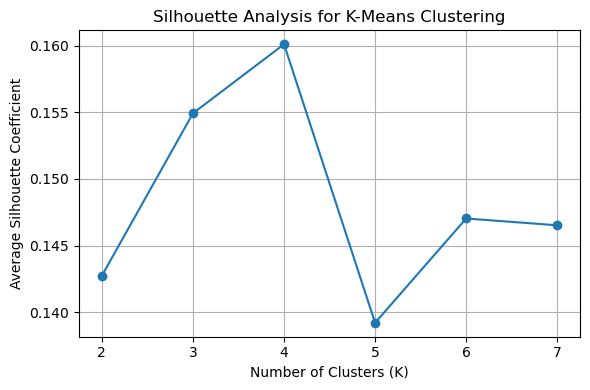

In [8]:
# Step 6: Final K-Means clustering

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(Feature_scaled)

Data["cluster"] = cluster_labels
Target = Data["cluster"].astype(int)

print(Data["cluster"].value_counts().sort_index())

ks = sorted(sil_scores.keys())
vals = [sil_scores[k] for k in ks]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ks, vals, marker="o")
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("Average Silhouette Coefficient")
ax.set_title("Silhouette Analysis for K-Means Clustering")
ax.grid(True)

fig.tight_layout()
plt.show()

In [9]:
cluster_summary = Data.groupby("cluster")[features].mean().round(2)
cluster_counts = Data["cluster"].value_counts().sort_index()
cluster_summary["Households"] = cluster_counts.values

cols = ["Households"] + [c for c in cluster_summary.columns if c != "Households"]
cluster_summary = cluster_summary[cols]

key_cols = ["Households", "TOTSQFT_EN", "MONEYPY", "KWH", "YEARMADERANGE"]
display(cluster_summary[key_cols])

,Households,TOTSQFT_EN,MONEYPY,KWH,YEARMADERANGE
cluster,,,,,
0,7159,2136.80,10.66,11262.21,4.34
1,3712,928.92,9.31,6156.67,4.54
2,72,1764.58,11.12,10149.81,4.79
3,7553,2300.94,13.72,12769.66,4.73


In [10]:
# Step 8: Cluster-level summaries

cluster_summary = Data.groupby("cluster")[features].mean()

energy_cols = [c for c in Data.columns 
               if ("BTU" in c.upper()) or ("KWH" in c.upper()) or ("BTUEL" in c.upper())]

if energy_cols:
    energy_summary = Data.groupby("cluster")[energy_cols].mean()
    display(energy_summary)

,KWH
cluster,
0,11262.206330
1,6156.667608
2,10149.811389
3,12769.664952


ANOVA Results
-------------
F-statistic: 1351.0910
p-value: 0.000000e+00

Tukey HSD Results
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.6237    0.0  -0.655 -0.5924   True
     0      2  -0.1523 0.1426 -0.3358  0.0311  False
     0      3   0.1294    0.0  0.1038  0.1549   True
     1      2   0.4714    0.0   0.287  0.6557   True
     1      3   0.7531    0.0   0.722  0.7842   True
     2      3   0.2817 0.0005  0.0983  0.4652   True
----------------------------------------------------


<Figure size 800x500 with 0 Axes>

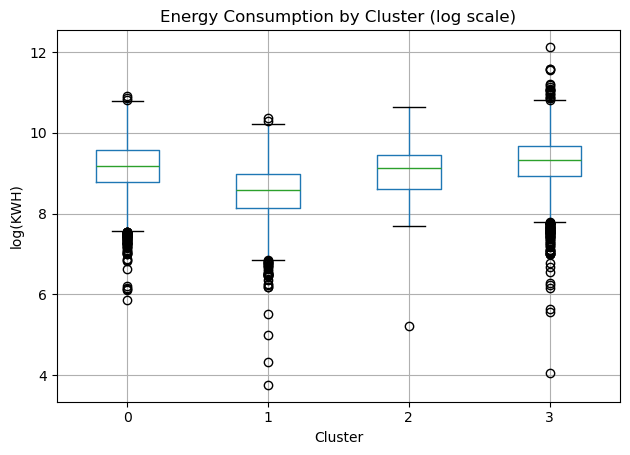

In [11]:
# Step 9: Statistical Validation of Clusters (ANOVA + Tukey HSD)

Data['log_KWH'] = np.log1p(Data['KWH'])

groups = [
    Data.loc[Data['cluster'] == c, 'log_KWH']
    for c in sorted(Data['cluster'].unique())
]

f_stat, p_value = f_oneway(*groups)

print("ANOVA Results")
print("-------------")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.6e}")

tukey = pairwise_tukeyhsd(
    endog=Data['log_KWH'],
    groups=Data['cluster'],
    alpha=0.05
)

print("\nTukey HSD Results")
print(tukey)

plt.figure(figsize=(8, 5))
Data.boxplot(column='log_KWH', by='cluster')
plt.title("Energy Consumption by Cluster (log scale)")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("log(KWH)")
plt.tight_layout()
plt.show()


Using predictors: ['TOTSQFT_EN', 'HHAGE']
Regression data shape: (18496, 3)
                            OLS Regression Results                            
Dep. Variable:                log_KWH   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     1631.
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:46:42   Log-Likelihood:                -17217.
No. Observations:               18496   AIC:                         3.444e+04
Df Residuals:                   18493   BIC:                         3.446e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

,Variable,VIF
0,const,12.617
1,TOTSQFT_EN,1.020
2,HHAGE,1.020


,Variable,Coefficient,P_value
0,const,8.7729,0.0
1,TOTSQFT_EN,0.0002,0.0
2,HHAGE,-0.0022,0.0


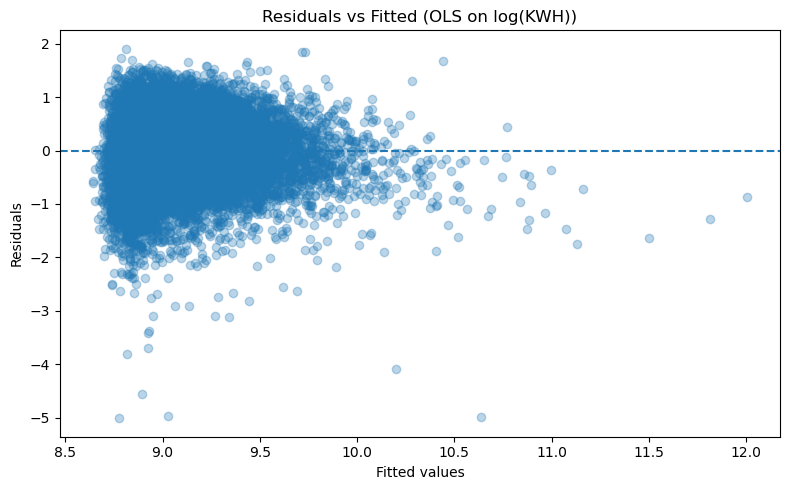

In [12]:
if "KWH" not in Data.columns:
    raise ValueError("KWH column not found in Data")

Data["log_KWH"] = np.log1p(Data["KWH"])

candidate_predictors = ["TOTSQFT_EN", "NHSLDMEM", "HDD65", "CDD65", "HHAGE"]
predictors = [c for c in candidate_predictors if c in Data.columns]

if len(predictors) < 2:
    raise ValueError(f"Not enough predictors found. Found: {predictors}")

print("Using predictors:", predictors)

df_reg = Data[predictors + ["log_KWH"]].dropna()

X = sm.add_constant(df_reg[predictors])   # add intercept
y = df_reg["log_KWH"]

print("Regression data shape:", X.shape)

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

vif_df = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

display(vif_df.round(3))

coef_table = pd.DataFrame({
    "Variable": ols_model.params.index,
    "Coefficient": ols_model.params.values,
    "P_value": ols_model.pvalues.values
}).sort_values("P_value")

display(coef_table.round(4))

plt.figure(figsize=(8, 5))
plt.scatter(ols_model.fittedvalues, ols_model.resid, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted (OLS on log(KWH))")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

PCR dataset -> X: (18496, 10) | y: (18496,)


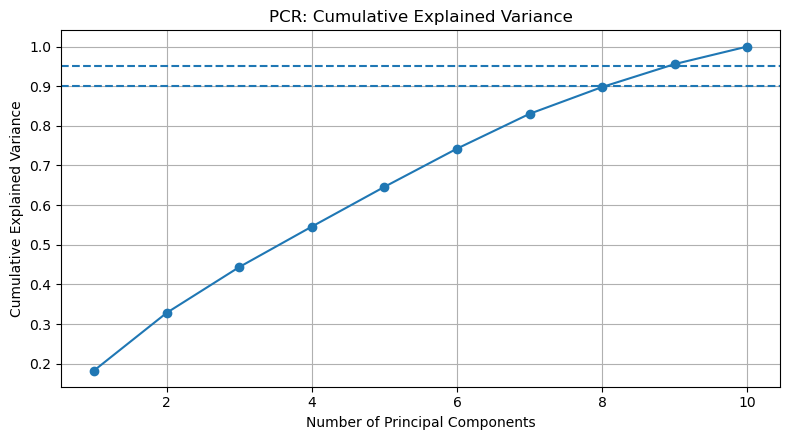

In [13]:
# Step 11: PCA-based Regression (PCR)

if "log_KWH" not in Data.columns:
    Data["log_KWH"] = np.log1p(Data["KWH"])

Data_pcr = Data.copy()
cat_cols = [c for c in ["REGIONC", "TYPEHUQ"] if c in Data_pcr.columns]
Data_pcr = pd.get_dummies(Data_pcr, columns=cat_cols, drop_first=True, dummy_na=True)

drop_cols = [c for c in ["KWH", "log_KWH", "cluster"] if c in Data_pcr.columns]
X_full = Data_pcr.drop(columns=drop_cols, errors="ignore").select_dtypes(include=[np.number]).copy()
y_full = Data_pcr["log_KWH"].copy()


reg_df = pd.concat([X_full, y_full], axis=1).dropna()
X_full = reg_df.drop(columns=["log_KWH"])
y_full = reg_df["log_KWH"]

print("PCR dataset -> X:", X_full.shape, "| y:", y_full.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

pca_all = PCA()
X_pca_all = pca_all.fit_transform(X_scaled)
explained = np.cumsum(pca_all.explained_variance_ratio_)

plt.figure(figsize=(8,4.5))
plt.plot(np.arange(1, len(explained)+1), explained, marker="o")
plt.axhline(0.90, linestyle="--")
plt.axhline(0.95, linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCR: Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

Selected number of PCs to reach ~95% variance: m = 9
PC matrix -> Train: (14796, 9) | Test: (3700, 9)

 PCR SUMMARY 

                            OLS Regression Results                            
Dep. Variable:                log_KWH   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     330.1
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:46:42   Log-Likelihood:                -13733.
No. Observations:               14796   AIC:                         2.749e+04
Df Residuals:                   14786   BIC:                         2.756e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

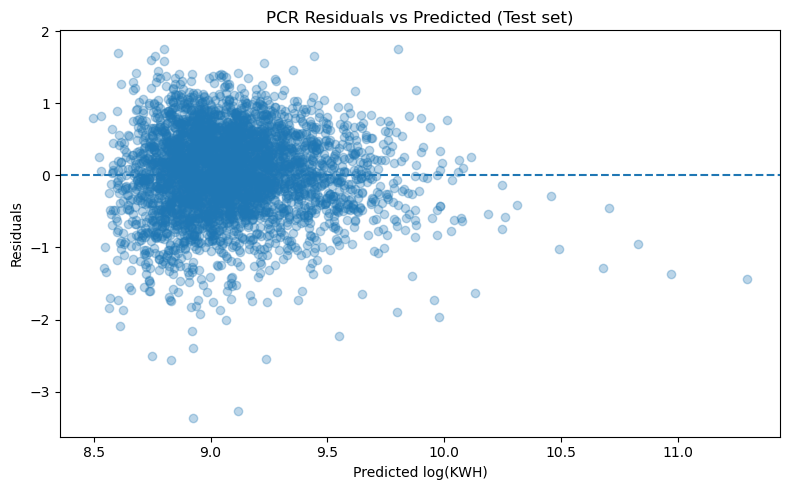


PCR Performance Metrics:


,n_PCs,R2_test,MAE_test,RMSE_test
0,9,0.168,0.4618,0.588


In [14]:
m = int(np.argmax(explained >= 0.95) + 1)
print(f"Selected number of PCs to reach ~95% variance: m = {m}")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_full, test_size=0.2, random_state=42
)

pca = PCA(n_components=m)
X_train_pcs = pca.fit_transform(X_train)
X_test_pcs = pca.transform(X_test)

print("PC matrix -> Train:", X_train_pcs.shape, "| Test:", X_test_pcs.shape)

X_train_pcs_sm = sm.add_constant(X_train_pcs)
X_test_pcs_sm = sm.add_constant(X_test_pcs)

pcr_model = sm.OLS(y_train, X_train_pcs_sm).fit()

print("\n PCR SUMMARY \n")
print(pcr_model.summary())

pred_test = pcr_model.predict(X_test_pcs_sm)

r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))

print("\n PCR TEST METRICS \n")
print(f"PCR Test R²  : {r2:.3f}")
print(f"PCR Test MAE : {mae:.3f}")
print(f"PCR Test RMSE: {rmse:.3f}")

residuals = y_test - pred_test

plt.figure(figsize=(8,5))
plt.scatter(pred_test, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.title("PCR Residuals vs Predicted (Test set)")
plt.xlabel("Predicted log(KWH)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

pcr_metrics = pd.DataFrame([{
    "n_PCs": m,
    "R2_test": r2,
    "MAE_test": mae,
    "RMSE_test": rmse
}])

from IPython.display import display

print("\nPCR Performance Metrics:")
display(pcr_metrics.round(4))

In [15]:
# ============================================================
# Step 12 : Clustering Variants Comparison (K-Means, K-Medoids,
#           Agglomerative, GMM)
# ============================================================

try:
    from sklearn_extra.cluster import KMedoids
    kmedoids_available = True
except ImportError:
    kmedoids_available = False
# 12.1 PCA features for clustering
if "X_pca" not in globals():
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    features = Data.select_dtypes(include=[np.number]).drop(
        columns=["KWH", "log_KWH", "cluster"], errors="ignore"
    ).dropna()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=6, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

print("PCA feature shape used for clustering:", X_pca.shape)


# 12.2 Number of clusters
K = Data["cluster"].nunique()
print("Number of clusters (K):", K)

results = []

def add_metrics(method, labels):
    results.append({
        "Method": method,
        "Silhouette": silhouette_score(X_pca, labels),
        "Calinski_Harabasz": calinski_harabasz_score(X_pca, labels),
        "Davies_Bouldin": davies_bouldin_score(X_pca, labels)
    })

# 12.3 K-Means (k-means++ default)
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_pca)
add_metrics("K-Means (k-means++)", labels_km)

# 12.4 K-Medoids (robust to outliers)
if kmedoids_available:
    kmed = KMedoids(
        n_clusters=K,
        random_state=42,
        init="k-medoids++"
    )
    labels_kmed = kmed.fit_predict(X_pca)
    add_metrics("K-Medoids", labels_kmed)

# 12.5 Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=K, linkage="ward")
labels_agg = agg.fit_predict(X_pca)
add_metrics("Agglomerative (Ward)", labels_agg)

# 12.6 Gaussian Mixture Model
gmm = GaussianMixture(n_components=K, random_state=42)
labels_gmm = gmm.fit_predict(X_pca)
add_metrics("GMM", labels_gmm)

# 12.7 Results comparison
results_df = pd.DataFrame(results)

print("\nClustering Comparison Results:\n")
print(results_df)

display(results_df.sort_values("Silhouette", ascending=False))
 

PCA feature shape used for clustering: (18496, 6)
Number of clusters (K): 4

Clustering Comparison Results:

                 Method  Silhouette  Calinski_Harabasz  Davies_Bouldin
0   K-Means (k-means++)    0.173006        3735.583337        1.375995
1             K-Medoids    0.127767        2142.828149        1.932241
2  Agglomerative (Ward)    0.166498        3158.838111        1.463363
3                   GMM    0.152270        2340.256272        1.625074


,Method,Silhouette,Calinski_Harabasz,Davies_Bouldin
0,K-Means (k-means++),0.173006,3735.583337,1.375995
2,Agglomerative (Ward),0.166498,3158.838111,1.463363
3,GMM,0.152270,2340.256272,1.625074
1,K-Medoids,0.127767,2142.828149,1.932241


In [16]:
# Step 13: Predictive model – Random Forest classifier

Target = Data["cluster"].astype(int)
Feature_full = Feature_imputed        

Feature_train, Feature_test, Target_train, Target_test = train_test_split(
    Feature_full, Target, test_size=0.3, random_state=42, stratify=Target
)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(Feature_train, Target_train)

Target_pred = rf.predict(Feature_test)
print(classification_report(Target_test, Target_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2148
           1       0.97      0.96      0.97      1114
           2       1.00      0.86      0.92        21
           3       0.98      0.99      0.98      2266

    accuracy                           0.98      5549
   macro avg       0.98      0.95      0.97      5549
weighted avg       0.98      0.98      0.98      5549



<Figure size 600x500 with 0 Axes>

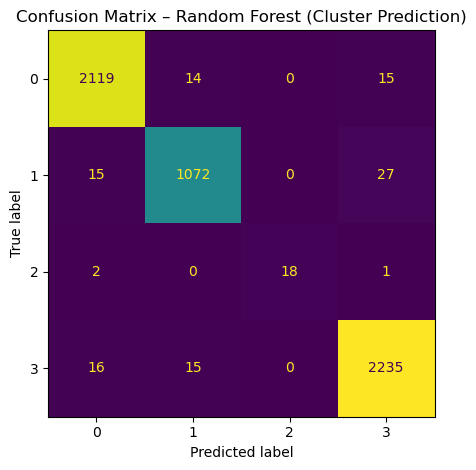

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix for Random Forest (Cluster Prediction)
rf_preds = rf.predict(Feature_test)

labels = sorted(np.unique(Target_test))
cm = confusion_matrix(Target_test, rf_preds, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 5))
disp.plot(values_format="d", colorbar=False)
plt.title("Confusion Matrix – Random Forest (Cluster Prediction)")
plt.tight_layout()
plt.show()


In [18]:
# Step 13b: Compare multiple classifiers for predicting clusters

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf",
        probability=True
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multiclass"
    )
}

results = []

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])
    else:
        pipe = Pipeline([
            ("clf", model)
        ])
    
    print("=" * 70)
    print(f"Training model: {name}")
    
    pipe.fit(Feature_train, Target_train)
    preds = pipe.predict(Feature_test)
    
    acc = accuracy_score(Target_test, preds)
    f1_macro = f1_score(Target_test, preds, average="macro")
    
    print(f"Test Accuracy:  {acc:.4f}")
    print(f"Test F1-macro:  {f1_macro:.4f}")
    print("\nClassification report:\n")
    print(classification_report(Target_test, preds))
    
    results.append({
        "Model": name,
        "Test Accuracy": acc,
        "Test F1_macro": f1_macro
    })

results_df = pd.DataFrame(results).sort_values("Test F1_macro", ascending=False)
display(results_df)

Training model: Logistic Regression


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy:  0.9960
Test F1-macro:  0.9967

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2148
           1       1.00      0.99      0.99      1114
           2       1.00      1.00      1.00        21
           3       0.99      1.00      1.00      2266

    accuracy                           1.00      5549
   macro avg       1.00      1.00      1.00      5549
weighted avg       1.00      1.00      1.00      5549

Training model: SVM
Test Accuracy:  0.9867
Test F1-macro:  0.9891

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2148
           1       0.98      0.98      0.98      1114
           2       1.00      1.00      1.00        21
           3       0.99      0.99      0.99      2266

    accuracy                           0.99      5549
   macro avg       0.99      0.99      0.99      5549
weighted avg       0.99

,Model,Test Accuracy,Test F1_macro
0,Logistic Regression,0.996035,0.996673
5,LightGBM,0.989908,0.991646
4,XGBoost,0.989908,0.991424
1,SVM,0.986664,0.989069
2,Decision Tree,0.975311,0.967970
3,Random Forest,0.981078,0.965080


In [19]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

results = []

for name, model in models.items():
    # Scale features for LR and SVM only
    if name in ["Logistic Regression", "SVM"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])
    else:
        pipe = Pipeline([
            ("clf", model)
        ])
    
    print("=" * 70)
    print(f"Training model: {name}")
    
    pipe.fit(Feature_train, Target_train)
    preds = pipe.predict(Feature_test)
    
    acc = accuracy_score(Target_test, preds)
    bal_acc = balanced_accuracy_score(Target_test, preds)
    macro_prec = precision_score(Target_test, preds, average="macro", zero_division=0)
    macro_rec = recall_score(Target_test, preds, average="macro", zero_division=0)
    f1_macro = f1_score(Target_test, preds, average="macro")
    mcc = matthews_corrcoef(Target_test, preds)
    
    print(f"Test Accuracy:         {acc:.4f}")
    print(f"Balanced Accuracy:     {bal_acc:.4f}")
    print(f"Macro Precision:       {macro_prec:.4f}")
    print(f"Macro Recall:          {macro_rec:.4f}")
    print(f"Macro F1-score:        {f1_macro:.4f}")
    print(f"Matthews Corr. Coeff.: {mcc:.4f}")
    print("\nClassification report:\n")
    print(classification_report(Target_test, preds))
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Balanced Accuracy": bal_acc,
        "Macro Precision": macro_prec,
        "Macro Recall": macro_rec,
        "Macro F1": f1_macro,
        "MCC": mcc
    })

results_df = pd.DataFrame(results).sort_values("Macro F1", ascending=False)
display(results_df)


Training model: Logistic Regression


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy:         0.9960
Balanced Accuracy:     0.9962
Macro Precision:       0.9972
Macro Recall:          0.9962
Macro F1-score:        0.9967
Matthews Corr. Coeff.: 0.9938

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2148
           1       1.00      0.99      0.99      1114
           2       1.00      1.00      1.00        21
           3       0.99      1.00      1.00      2266

    accuracy                           1.00      5549
   macro avg       1.00      1.00      1.00      5549
weighted avg       1.00      1.00      1.00      5549

Training model: SVM
Test Accuracy:         0.9867
Balanced Accuracy:     0.9888
Macro Precision:       0.9893
Macro Recall:          0.9888
Macro F1-score:        0.9891
Matthews Corr. Coeff.: 0.9793

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2148
           1       0.98   

,Model,Accuracy,Balanced Accuracy,Macro Precision,Macro Recall,Macro F1,MCC
0,Logistic Regression,0.996035,0.996161,0.997195,0.996161,0.996673,0.993836
5,LightGBM,0.989908,0.990879,0.992437,0.990879,0.991646,0.984303
4,XGBoost,0.989908,0.990879,0.991982,0.990879,0.991424,0.984302
1,SVM,0.986664,0.988832,0.989311,0.988832,0.989069,0.979260
2,Decision Tree,0.975311,0.968032,0.967907,0.968032,0.967970,0.961611
3,Random Forest,0.981078,0.948065,0.984862,0.948065,0.965080,0.970553


Best model selected based on Macro F1: Logistic Regression


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 600x500 with 0 Axes>

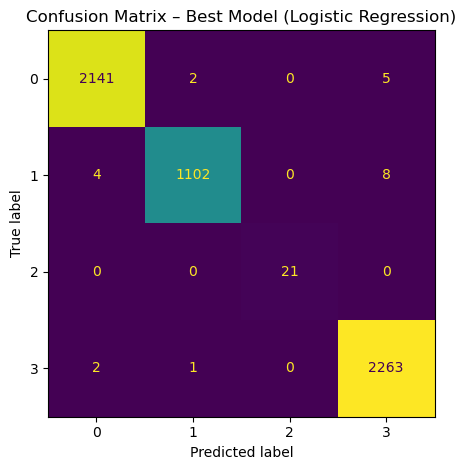

In [20]:
# 1) Identify best model based on Macro F1
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print("Best model selected based on Macro F1:", best_model_name)

if best_model_name in ["Logistic Regression", "SVM"]:
    best_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", best_model)
    ])
else:
    best_pipe = Pipeline([
        ("clf", best_model)
    ])

best_pipe.fit(Feature_train, Target_train)
best_preds = best_pipe.predict(Feature_test)

# 4) Confusion Matrix
labels = sorted(np.unique(Target_test))
cm = confusion_matrix(Target_test, best_preds, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 5))
disp.plot(values_format="d", colorbar=False)
plt.title(f"Confusion Matrix – Best Model ({best_model_name})")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", models["Logistic Regression"])
])

cv_acc = cross_val_score(lr_pipe, Feature_full, Target, cv=skf, scoring="accuracy")
cv_f1 = cross_val_score(lr_pipe, Feature_full, Target, cv=skf, scoring="f1_macro")

print(f"Logistic Regression 5-fold CV Accuracy:  mean={cv_acc.mean():.4f}, std={cv_acc.std():.4f}")
print(f"Logistic Regression 5-fold CV Macro F1:  mean={cv_f1.mean():.4f}, std={cv_f1.std():.4f}")

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in ve

Logistic Regression 5-fold CV Accuracy:  mean=0.9975, std=0.0008
Logistic Regression 5-fold CV Macro F1:  mean=0.9979, std=0.0007


len(importances) = 11
len(feature_names) = 11
EMPLOYHH         0.394038
TYPEHUQ          0.216443
HHAGE            0.119136
ROOFTYPE         0.105048
TOTSQFT_EN       0.055353
MONEYPY          0.050730
KWH              0.028309
WALLTYPE         0.015965
YEARMADERANGE    0.007472
ADQINSUL         0.005203
HHSEX            0.002303
dtype: float64


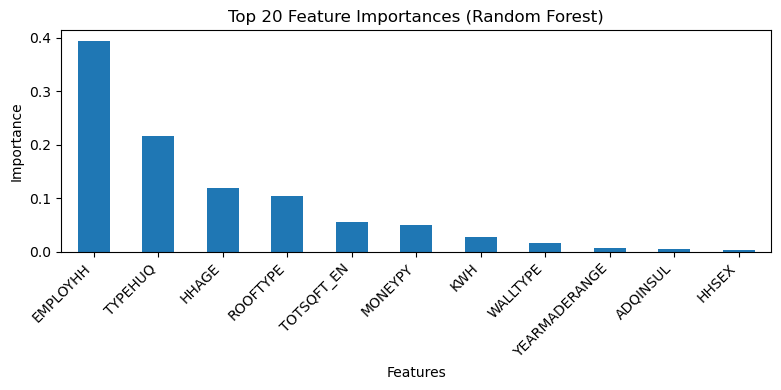

In [22]:
if "Feature_full" in globals() and hasattr(Feature_full, "columns"):
    feature_names = Feature_full.columns
elif "X_full" in globals() and hasattr(X_full, "columns"):
    feature_names = X_full.columns
elif "encoded" in globals() and hasattr(encoded, "columns"):
    feature_names = encoded.columns
else:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

print("len(importances) =", len(rf.feature_importances_))
print("len(feature_names) =", len(feature_names))

feat_importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

print(feat_importance.head(20))

feat_importance.head(20).plot(kind='bar', figsize=(8,4))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
Data['cluster'].value_counts()

cluster
3    7553
0    7159
1    3712
2      72
Name: count, dtype: int64